In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
file = '/content/drive/MyDrive/ColabNotebooks/Pinn/U1.txt'

In [3]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

In [4]:
# Definición del modelo con más capas y unidades
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN), activation()])
        self.fch = nn.Sequential(*[
            nn.Sequential(*[
                nn.Linear(N_HIDDEN, N_HIDDEN),
                activation()]) for _ in range(N_LAYERS)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [6]:
# Cargar los datos
data = pd.read_csv(file, sep=" ", header=None)
N = 5
t_obs = data.iloc[:N, 0]
u_obs = data.iloc[:N, 1]
# Scaling
#u_obs *= 100 # Pasamos a centrimetros

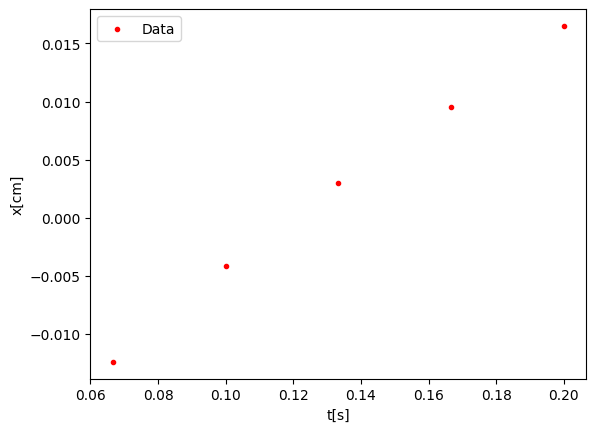

In [7]:
plt.scatter(t_obs, u_obs, color='r', marker='.',label='Data')
plt.xlabel('t[s]',fontsize=10)
plt.ylabel('x[cm]',fontsize=10)
plt.legend()
plt.show()

In [8]:
# Conversión a tensores de PyTorch
t_obs = torch.tensor(t_obs.values).float().view(-1, 1)
u_obs = torch.tensor(u_obs.values).float().view(-1, 1)

# Prueba del modelo
t_test = torch.linspace(t_obs[0].item(), t_obs[-1].item(), N).view(-1, 1)

torch.manual_seed(123)

# Aumentar el número de capas y unidades
pinn = FCN(1,1,70,7)  # Ahora 6 capas ocultas con 50 unidades cada una


mu = torch.nn.Parameter(torch.tensor([0.5], requires_grad=True))  # Iniciar mu con 0.1
w0 = torch.nn.Parameter(torch.tensor([9.], requires_grad=True))  # Iniciar w0 con 0.1

# Añadir mu y w0 al optimizador
optimiser = torch.optim.Adam(list(pinn.parameters()) + [mu, w0], lr=1e-3)

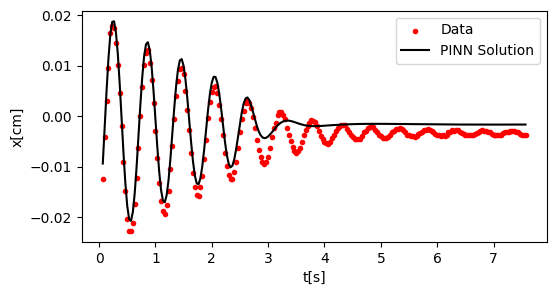

In [ ]:
mu_param = []
w0_param = []

# Coeficientes de ponderación
lambda_physics = 1e2
lambda_data = 1e6  # Puedes ajustar este valor según la importancia relativa

N = 69

for i in range(100001):

    optimiser.zero_grad()

    data = pd.read_csv(file, sep=" ", header=None)
    t_obs = data.iloc[:N, 0]
    u_obs = data.iloc[:N, 1]

   # u_obs *= 100

    t_obs = torch.tensor(t_obs.values).float().view(-1, 1)
    u_obs = torch.tensor(u_obs.values).float().view(-1, 1)

    # Compute physics loss
    t_physics = torch.linspace(t_obs[0].item(), t_obs[-1].item(), N).view(-1, 1).requires_grad_(True)
    t_test = torch.linspace(t_obs[0].item(), t_obs[-1].item(), N).view(-1, 1)
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]

    # Nueva pérdida física
    loss_physics = torch.mean((d2udt2 + mu * dudt + (w0 ** 2) * u) ** 2)

    # Compute data loss
    u_pred = pinn(t_obs)
    loss_data = torch.mean((u_pred - u_obs) ** 2)

    # Pérdida total
    loss = lambda_physics * loss_physics + lambda_data * loss_data
    loss.backward()

    if loss.item() < 10 and N < data.shape[0]:
      N += 1

    if loss.item() < 100:
      for param_group in optimiser.param_groups:
        param_group['lr'] = 6e-4

    if loss.item() < 20:
      for param_group in optimiser.param_groups:
        param_group['lr'] = 2e-4

    if loss.item() < 1:
      for param_group in optimiser.param_groups:
        param_group['lr'] = 1e-5

    optimiser.step()

    # Record mu and w0 values
    mu_param.append(mu.item())
    w0_param.append(w0.item())

    if i % 100 == 0:

        clear_output(wait=True)
        # Imprimiendo la tasa de aprendizaje
        for param_group in optimiser.param_groups:
          print("Learning rate:", param_group['lr'])

        print('Data: ',N)
        print(f"Step {i}: Loss = {loss.item()}, Mu = {mu.item()}, w0 = {w0.item()}")
        u_test = pinn(t_test).detach()
        plt.figure(figsize=(6, 3))
        #plt.title(f"Training step {i}")
        plt.scatter(t_obs, u_obs, color='r', marker='.',label='Data')
        plt.plot(t_test[:, 0], u_test[:, 0], color='k', label='PINN Solution')
        plt.xlabel('t[s]',fontsize=10)
        plt.ylabel('x[cm]',fontsize=10)
        plt.legend()
        plt.show()
        time.sleep(0.01)

In [ ]:
print(N)

68


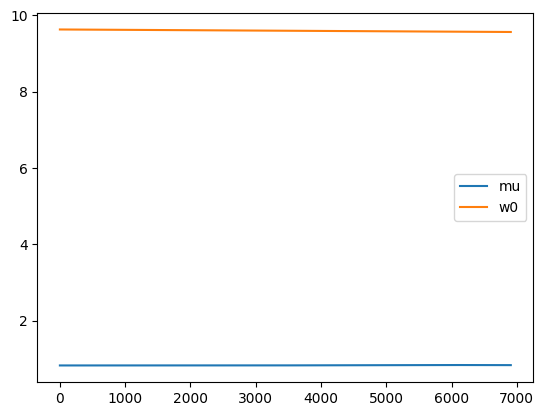

In [ ]:
plt.plot(mu_param, label='mu')
plt.plot(w0_param, label='w0')
plt.legend()
plt.show()

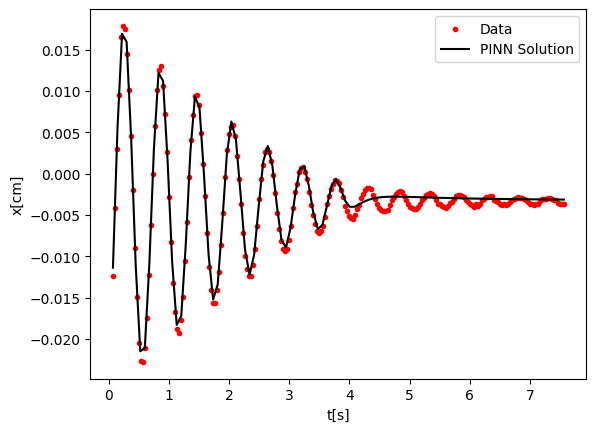

In [ ]:
# probando sobre todo el espectro
t1_obs = data.iloc[:,0]
u1_obs = data.iloc[:,1]

# Conversión a tensores de PyTorch
t1_obs = torch.tensor(t1_obs.values).float().view(-1, 1)
u1_obs = torch.tensor(u1_obs.values).float().view(-1, 1)

t1_test = torch.linspace(t1_obs[0].item(), t1_obs[-1].item(), 100).view(-1, 1)
u1_test = pinn(t1_test).detach()

plt.scatter(t1_obs, u1_obs, color='r', marker='.',label='Data')
plt.plot(t1_test[:, 0], u1_test[:, 0], color='k',label='PINN Solution')
plt.xlabel('t[s]',fontsize=10)
plt.ylabel('x[cm]',fontsize=10)
plt.legend()
plt.savefig('/content/drive/MyDrive/Pinn_fitting.pdf')
plt.show()